In [1]:
import pandas as pd
import math
import re
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
import enchant
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import EnglishStemmer
import lda
from dateutil import parser
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from pyelasticsearch import ElasticSearch
from time import time
pd.options.display.max_colwidth = 140
%matplotlib inline

# Trump data acquisition and description

We have acquired the data via the link provided in the projects datasets. We have accessed the following link : http://www.trumptwitterarchive.com/archive and downloaded all of Trump's tweets in csv format.<br/>
The data had the following fields :<br/>
1. source : contains the platform used to create the tweet
2. text : the content of the tweet
3. created_at : the date of the tweet
4. retweet_count : the number of times this tweet has been retweeted
5. favorite_count : the number of times this tweet was favorited
6. is_retweet : boolean value indicating whether or not this tweet was a retweet
7. id_str : the unique identifier of a tweet

From the previous fields, we will need : the text field in order to do the topic extraction, the created_at field to plot the topics on a timeline, favorite_count and retweet_count as basic indicators of a tweet's popularity.<br/>

In [2]:
# load the Trump tweets data set
trump_df = pd.read_csv('trump_tweets.csv',encoding = "ISO-8859-1")
trump_df.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,Leaving South Korea now heading to China. Looking very much forward to meeting and being with President Xi!,11.08.17 4:57,4901.0,23854,FALSE,9.281240e+17
1,Twitter Web Client,Together we dream of a Korea that is free a peninsula that is safe and families that are reunited once again! https://t.co/9tsZRCC83j,11.08.17 3:43,6232.0,22850,FALSE,9.281060e+17
2,Twitter Web Client,Anyone who doubts the strength or determination of the U.S. should look to our past....and you will doubt it no longer. https://t.co/zyu...,11.08.17 3:14,6648.0,24794,FALSE,9.280980e+17
3,Twitter Web Client,The North Korean regime has pursued its nuclear &amp; ballistic missile programs in defiance of every assurance agreement &amp; commmitm...,11.08.17 3:12,5513.0,19798,FALSE,9.280980e+17
4,Twitter Web Client,The U.S. under my administration is completely rebuilding its military and they're spending hundreds of billions of dollars to the newes...,11.08.17 3:09,7325.0,26769,FALSE,9.280970e+17


# Twitter dump data acquisition and description

For now we have managed to download a small portion of the twitter data from the cluster in order to see the different features that are available to us. The data contains no header, but looking at the first few rows, we were able to identify the features. 
The data has the following fields: <br/>
1. language : the language of the tweet
2. tweet_id : the unique identifier of a tweet
3. date_time : the date and time at which a tweet was made 
4. user : the handle of the user that tweeted 
5. text : the content of the tweet

We do not need to work on all the tweets in the dataset. The next step wwould be to run a PySpark script on the cluster to filter them and get only a subset relevant to our task.
Filtering will be based on the following criteria: 
1. The language of the tweet is English
2. The tweet's text contains Donald Trump's twitter handle, which means that it is either in reply to Trump or a retweet

After acquiring the relevant data, we will use the text field of the tweet to perform sentiment analysis. 

In [3]:
# load the Twitter dump first 1000 tweets data set
tweets_df = pd.read_csv('tweets_1000.txt',encoding = "ISO-8859-1", sep="\t", header = None)
tweets_df.columns=['language', 'tweet_id', 'date_time', 'user', 'text']
tweets_df.head()

,language,tweet_id,date_time,user,text
0,en,3.459639e+17,Sat Jun 15 18:00:01 +0000 2013,Letataleta,RT @silsilfani: the world is not a wish-granting machine. dont be surprised when everything always end up disappointing.
1,en,3.459639e+17,Sat Jun 15 18:00:01 +0000 2013,JamesonN7,RT @WhosThisHoe: I'd rather sleep with a nice guy because they always finish last
2,en,3.459639e+17,Sat Jun 15 18:00:01 +0000 2013,LauraEllynJones,Can't stand people who lie then blame it on someone else #boreoff
3,it,3.459639e+17,Sat Jun 15 18:00:01 +0000 2013,ChialettaFClub,@ChialettaFClub: #rt seguimi ti seguo ti voto il profilo\nX9\nOBBIETTIVO:300
4,fr,3.459639e+17,Sat Jun 15 18:00:01 +0000 2013,_irem61_,RT @DHC_Music: Terrorism ... #FreePalestina http://t.co/OLWnVlW682


# Trump tweets pre-processing
We define different functions in order to clean the text to be able to perform better topic extraction. 
First, we get rid of contractions in any word (don't, doesn't, won't etc.). We also remove any URLs from the data. We get rid of any special characters and punctuation. We also remove any words that contain numbers. The clean text function applies all the aforementioned modifications to a tweet.  It also retains only alphanumeric characters as some of the tweets contained Japanese characters for example. In addition, the clean text function also performs word lemmatization, so that words with similar meaning get represented in the same way. <br/>
Note that some of these functions can also be used when cleaning the Twitter dump data before doing the sentiment analysis on them.

In [4]:
def fix_contractions(document):
    """
    Remove contractions from document
    :param document: where we want to remove the contractions
    :return: the document without contractions
    """
    match_list = re.findall(r"\w+(?=n't)|n't|\w+(?=')|'\w+|\w+",document, re.IGNORECASE | re.DOTALL)
    ans = " ".join(match_list)
    return ans.lstrip().rstrip()

def remove_link(document):
    """
    Remove links and fix U.S. shortname
    :param document: where we want to remove the link
    :return: the document without a link
    """
    result = ""
    for word in document.split():
        if(not(word[:4] == "http") and not(word[0] == '&') and not(word[len(word)-1] == ';')):
            if(word == "u.s."):
                result += " usa"
            else:
                result += " " + word

    return result.lstrip().rstrip()

def remove_special_characters(documents):
    """
    Remove special characters
    :param documents: the documents from where we remove the characters
    :return: the documents without the special characters
    """
    documents_no_specials = []
    for item in documents:
        try:
            documents_no_specials.append(
                item.replace('\r', ' ').replace('/n', ' ')\
                    .replace('.', ' ').replace(',', ' ').replace('(', ' ') \
                    .replace(')', ' ').replace('"', ' ') \
                    .replace('!', ' ').replace('?', ' ') \
                    .replace('>', ' ').replace('$', ' ') \
                    .replace('-', ' ').replace(';', ' ') \
                    .replace(':', ' ').replace('/', ' ').replace('#', ' ').replace('@',' '))
        except:
            documents_no_specials.append("")
    
    result = ""
    for ch in documents_no_specials:
            result = result + ch
    return result

def remove_numerical(documents):
    """
    remove the words containing numbers
    :param documents: 
    :return: 
    """
    result = ""
    for word in documents.split():
        new_word = ''.join([i for i in word if not i.isdigit()])
        result = result + " " + new_word
    return result

def clean_text(documents):
    """
    remove special characters, stop words and numbers, lemmatize and remove non-english words 
    :param documents: Docuements to clean
    :param tester: which element you would like to display as an example
    :return: the cleaned documents
    """
    lemmatizer = WordNetLemmatizer()

    # Remove numbers
    documents_no_link_no_numeric = remove_numerical(documents)
    
    #Everything to lower case
    documents = documents_no_link_no_numeric.lower()
    
    # Remove links
    documents_no_link = remove_link(documents)
    
    # Remove special characters
    documents_no_specials = remove_special_characters(documents_no_link)
    
    #Remove contractions
    documents_fixed_words = fix_contractions(documents_no_specials)
  
    # remove words with length equal to 1
    documents_remove_shortwords = " ".join([token for token in documents_fixed_words.split() 
                                                       if (len(token)>1)])
    
    documents_finished = re.sub('[^a-zA-Z]+', ' ',documents_remove_shortwords)
    
    documents_finished = " ".join([token for token in documents_finished.split() if (token not in STOPWORDS)])
    
    documents_finished = " ".join([lemmatizer.lemmatize(token) for token in documents_finished.split()])
    
    # remove words with length equal to 1
    documents_finished = " ".join([token for token in documents_finished.split() 
                                                       if (len(token)>1)])
    
    #remove specific words
    documents_finished = " ".join([token for token in documents_finished.split() if (not token in "realdonaldtrump")])
    
    return documents_finished


We apply the clean text function to the text column of the dataframe, and obtain a dataframe with the clean text, on which we can try different topc identifiation methods. <br/>
We then remove any rows for which the text field became empty after preprocessing. <br/>
We also save the clean tweets dataframe to a new csv file so that wwe can use it easily.

In [5]:
#Apply clean text to entire column
trump_df['text'] = trump_df['text'].apply(clean_text)
# Remove empty rows
trump_df = trump_df[trump_df['text'] != '']
#Save processed tweets
trump_df.to_csv("trump_tweets_processed.csv")

trump_df.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,leaving south korea heading china looking forward meeting president xi,11.08.17 4:57,4901.0,23854,FALSE,9.281240e+17
1,Twitter Web Client,dream korea free peninsula safe family reunited,11.08.17 3:43,6232.0,22850,FALSE,9.281060e+17
2,Twitter Web Client,doubt strength determination usa look past doubt longer,11.08.17 3:14,6648.0,24794,FALSE,9.280980e+17
3,Twitter Web Client,north korean regime pursued nuclear ballistic missile program defiance assurance agreement commmitment usa ally broken commitment,11.08.17 3:12,5513.0,19798,FALSE,9.280980e+17
4,Twitter Web Client,usa administration completely rebuilding military spending hundred billion dollar newest finest military equipment world built right wan...,11.08.17 3:09,7325.0,26769,FALSE,9.280970e+17


## Read preprocessed trump tweets

We directly read all the pre-processed tweets instead of rerunning the clean text function many times

In [6]:
# Load pre-processed trump tweets
trump_df = pd.read_csv('trump_tweets_processed.csv',encoding = "ISO-8859-1")
trump_df.head()

,Unnamed: 0,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,0,Twitter for iPhone,leaving south korea heading china looking forward meeting president xi,11.08.17 4:57,4901.0,23854.0,False,9.281240e+17
1,1,Twitter Web Client,dream korea free peninsula safe family reunited,11.08.17 3:43,6232.0,22850.0,False,9.281060e+17
2,2,Twitter Web Client,doubt strength determination usa look past doubt longer,11.08.17 3:14,6648.0,24794.0,False,9.280980e+17
3,3,Twitter Web Client,north korean regime pursued nuclear ballistic missile program defiance assurance agreement commmitment usa ally broken commitment,11.08.17 3:12,5513.0,19798.0,False,9.280980e+17
4,4,Twitter Web Client,usa administration completely rebuilding military spending hundred billion dollar newest finest military equipment world built right wan...,11.08.17 3:09,7325.0,26769.0,False,9.280970e+17


# Topic extraction experimentation

We experiment with several topic extraction techniques on the Trump tweets dataset. <br/>
Note that these analyses are only preliminary analyses. We need to select one of them and tune it in order to obtain better results. <br/>
We experiment with Latent Semantic Analysis (LSA), Latent Dirichlet Allocation (LDA), and Elastic Search.<br/>

For LSA and LDA, we try to extract 16 topics from Trump's tweets. Again, we chose this number only for a preliminary analysis.

In [7]:
# Number of topic for LSA and LDA
n_topics = 16

### 1. Latent Semantic Analysis for topic extraction
We first try LSA to extract 16 topics from Trump's tweets. We then enumerate al the words that were classified into that topic by the model.

In [8]:
#use tfidf vectorizer to vectorize the text of the tweet
tfvectorizer = TfidfVectorizer()
X = tfvectorizer.fit_transform(trump_df['text'])
#fit lsa model to vectorized text
lsa = TruncatedSVD(n_components=n_topics,n_iter=100)
lsa.fit(X)
terms = tfvectorizer.get_feature_names()

In [9]:
#display main words for each of the topics
for i,comp in enumerate(lsa.components_):
    termsInComp = zip(terms,comp)
    sortedItems = sorted(termsInComp, key=lambda x: x[1],reverse=True)[:20]
    print ("Topic {} :".format(i+1))
    for term in sortedItems:
        print (term[0]," ",end='')
    print ("\n")

Topic 1 :
great  thank  america  president  thanks  twitter  false  need  android  run  country  people  new  job  makeamericagreatagain  time  vote  like  good  obama  

Topic 2 :
thank  makeamericagreatagain  america  poll  new  americafirst  support  carolina  hampshire  imwithyou  florida  nice  trumphttps  iowa  votetrump  south  pennsylvania  supertuesday  honor  maga  

Topic 3 :
great  america  job  let  hard  work  honor  night  today  crowd  safe  tonight  day  guy  fantastic  book  congratulation  crippled  new  going  

Topic 4 :
thanks  thank  great  true  nice  luck  awesome  good  love  billmaher  tie  beaumontanthony  inspiration  amazing  beautiful  honor  fantastic  trumptowerny  makeamericagreatagain  word  

Topic 5 :
president  run  need  america  country  vote  obama  mr  leader  save  united  let  running  fix  state  leadership  american  hope  man  thank  

Topic 6 :
twitter  false  america  android  web  client  great  run  need  president  mr  thank  iphone  

We notice that this method does not help us much with our analysis and that the words that fall under the same topic are not always related to each other. 

# Latent Dirichlet Allocation for topic extraction
We then try LDA, using the same number of topics that we used for LSA. Again, we enumerate the words that fall under a certain topic.

In [10]:
#use tfidf vectorizer
tfvectorizer = TfidfVectorizer()
X = tfvectorizer.fit_transform(trump_df['text'])
#fit LDA model
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(X)


def display_topics(model, feature_names, no_top_words):
    """
    display to topics and most important words
    :param model: the lda model to use
    :param feature_names: the word vocabulary
    :param no_top_words: the number of most important words to display
    :return: 
    """
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic {}:".format(topic_idx+1))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]), "\n")

#show the top 20 most important words in a topic
no_top_words = 20
tf_feature_names = tfvectorizer.get_feature_names()
display_topics(lda, tf_feature_names, no_top_words)


Topic 1:
enjoy foxandfriends tonight gretawire interview interviewed pm fox rosie morning greta monday foxnews melaniatrump boardroom oreillyfactor squawkcnbc blog seanhannity todayshow 

Topic 2:
opec river joan collection gold agschneiderman wise dubai spitzer theapprentice olympic skyline trumpadvice tahmooressi smith acre sgt designed downtown unsustainable 

Topic 3:
finale alexsalmond trumplasvegas ivankatrump admit stern faith jonhuntsman coincidence generation pinehurst bid windfarms vattenfallgroup december inspired theartofthedeal rob entertainment irs 

Topic 4:
great barackobama new thank good america thanks cont twitter false time today like love job people think obama best night 

Topic 5:
entrepreneur birthday happy yes unemployment global warming market shirt tea anthony ivanka breitbartnews keystone song jack expect birth fiscal gut 

Topic 6:
momentum trumpnewyork atrium shock tara conner foot therealkiyosaki fifth pianobecca webb sand mayweather apply deserter savvy 

Similar to LSA, the results of LDA are not very relevant. 

# Elastic Search

Finally, we try Elastic Search. The problem here is that Elastic Search is based on queries. Therefore we would hav to predefined certain topics, with a list of words under each of the topics, in order to run Elastic Search.

In [11]:
# indexing tweets
csv_filename="trump_tweets_processed.csv"

t0=time()

# size of the bulk
chunksize=5000

# open csv file
f = open(csv_filename) # read csv

# parse csv with pandas
csvfile=pd.read_csv(f, iterator=True, chunksize=chunksize) 

# init ElasticSearch
es = ElasticSearch('http://localhost:9200/')

# init index
try :
    es.delete_index("tweets")
except :
    pass

es.create_index("tweets")

# start bulk indexing 
print ("now indexing %s..."%(csv_filename))

for i,trump_df in enumerate(csvfile): 
    print (i)
    records=trump_df.where(pd.notnull(trump_df), None).T.to_dict()
    list_records=[records[it] for it in records]
    try :
        es.bulk_index("tweets","tweet",list_records)
    except :
        print ("error!, skiping some tweets sorry")
        pass

print ("done in %.3fs"%(time()-t0))

now indexing trump_tweets_processed.csv...
0
1
2
3
4
5
done in 9.134s


We construct a dictionnary of general topics that may occur in Donald Trump's tweets with a list of words that fall under that topic as a value. <br/>
For each topics, we perform an elastic search with the words that fall under that specific topic as the query, to see which tweets in the dataset fall under that topic.

In [12]:
# dictionnary of topics and relevant words to that topic
topics_dict= {"abortion": "abortion parenthood womb embryonic embryon",
"economy" : "financial gdp growth economic interest depression recovery refinance finance economy budget loan money bankrupt",
"civil_rights" : "racist racism black minorities minority minoritie minoriti mosques sexual equality gay misogynist tolerate tolerance blacks jews jew women",
"corporations" : "business taxes tax taxe job money boom corporate capitalism wealth litigation",
"crime" : "victims crime gang drug law order police death muderer violent judge accountable criminal",
"drugs" :"drug drugs opioids pot alcohol marijuana",
"education" :"school education scholarship student teach study teacher",
"environment" : "environments miners animal epa coal carbon oil miner energy epa climate solar panel oil windmill solar drilling drill",
"foreign_policy" : "pakistan cuba korea iran nato brexit nuclear arms army negotation negotiator russia us u.s. israel alliance islamic nuke syrian syria rebel mideast arab sanction sanctions russian diplomacy putin china isis",
"trade" : "nafta trade imported import export exported vat currency tpp",
"gun" : "military gun violence arm weapon assault shooting shoot armor ammunition nra rifle",
"healthcare" : "obamacare health vaccination doctor insurance medicare medicaid virus va healthcare",
"immigration" : "immigration amnesty visa visas refugee refugees border resident citizenship ban banning wall",
"jobs" : "job jobs unemployment unemployed hire hired wage",
"tax" : "tax debt taxes tax",
"technology" : "infrastructure airport railway road innovation internet net cyber cyberattack"
}


We perform elastic search for every topic and plot the number of tweets where that topic appears with respect to time just to have an initial idea of the results.

Tweets on abortion :  

rt teamtrump timkaine abortion flip flop valuing sanctity life pro abortion demagogue vpdebate 

macy big contributor ppfa anybody planned parenthood boycott racial profiling macy 

democrat smiling freedom caucus help club growth heritage saved planned parenthood ocare 



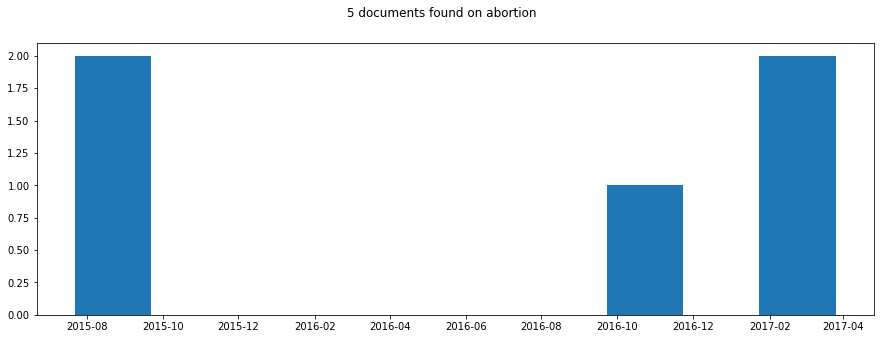

Tweets on economy :  

usa recorded slowest economic growth year gdp trade deficit hurt economy badly 

quarter gdp lowered wo economic recovery barackobama defeated 

economy worst recovery obama depression result policy speak new tax 



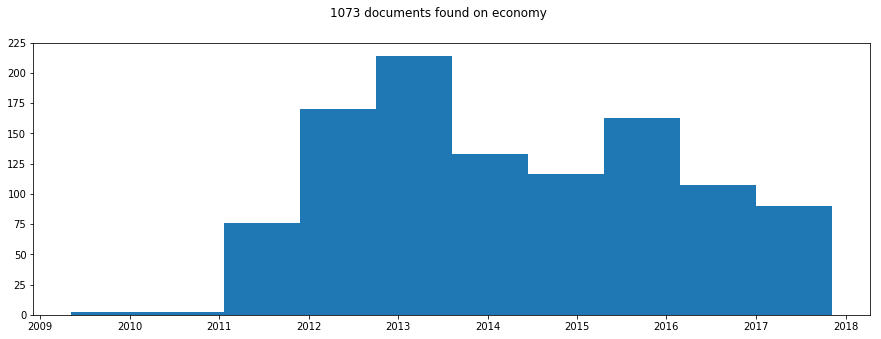

Tweets on civil_rights :  

state senator shirley huntley ratted black politician believed ratted agschneiderman listened racism 

thr abc black ish title racist 

black politician prison based shirley huntley statement white agschneiderman racism 



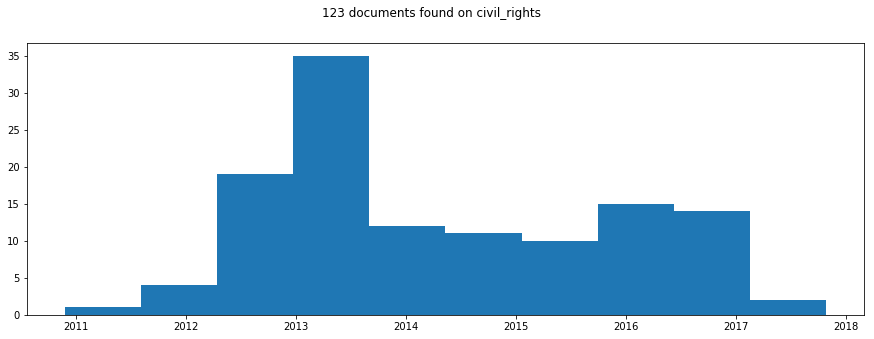

Tweets on corporations :  

want job slash corporate tax rate tax incentive company create job america boom 

ca tax business business pay tax collect tax ronald reagan 

america labor market continues boom job job job 



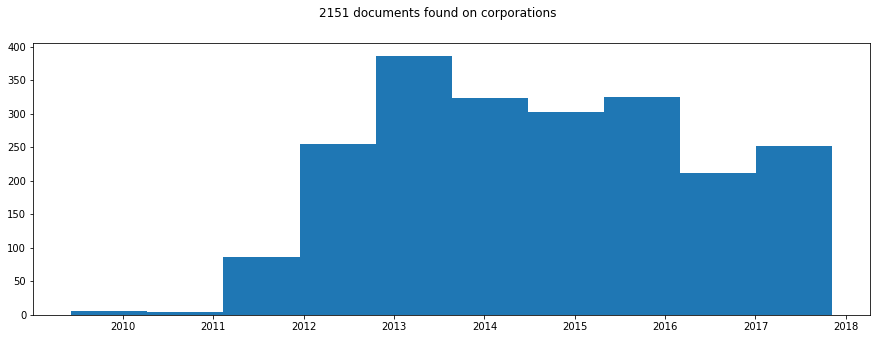

Tweets on crime :  

shooting death police officer year restore law order protect great law enforcement officer 

likewise primary victim violent crime african american hispanic community people want law order 

mayor mikebloomberg police commissioner ray kelly violent crime nyc dramatically leadership 



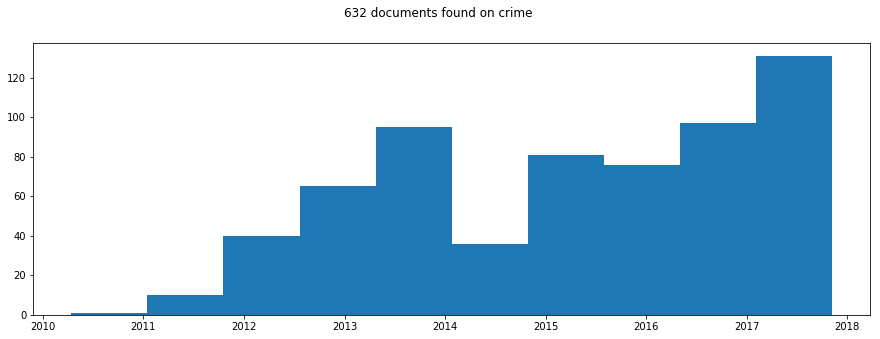

Tweets on drugs :  

jayedavaughn currently stir pot lmao apprenticenbc celebapprentice 

getting rid glenfiddich garbage alcohol property 

thank american participated nat rx drug day record drug collected disposed 



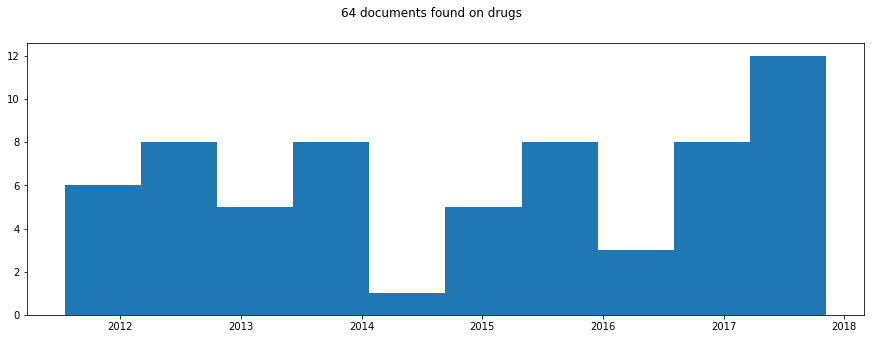

Tweets on education :  

bat parent education high priority important went best school cont 

onus chicago teacher strike fall squarely teacher union inexcusable leave child school 

school pay attention education money machine think like billionaire 



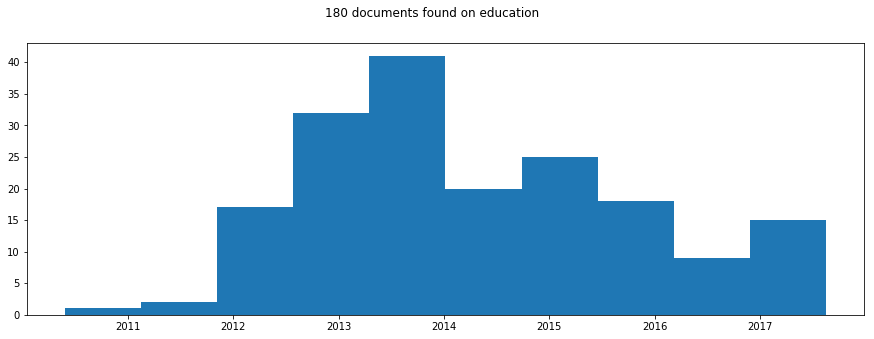

Tweets on environment :  

windmill bigger safety hazard coal oil higher mortality rate coal outrageous 

gshuba windmill worth trouble worse planet oil carbon et true 

obama zero credibility oil coal win energy country win period 



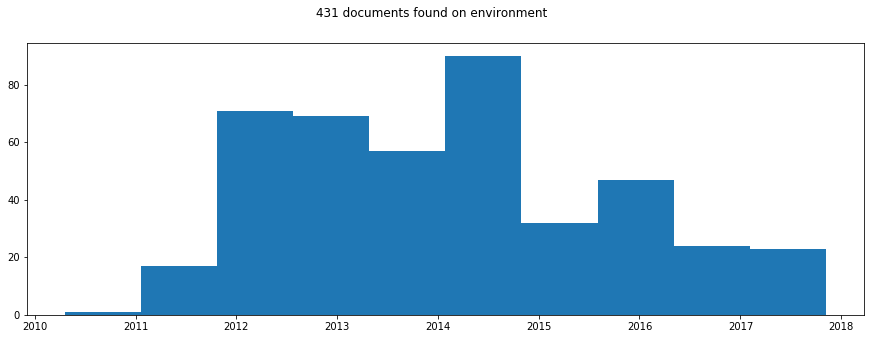

Tweets on foreign_policy :  

american sanction stop iran nuclear drive barackobama china russia agree new iranian sanction 

gregfrech seen video rebel commander cutting eating syrian soldier heart liver false twitter android waiting prepared attack syria maybe knock hell iran nuclear capability false twitter android look horrible picture page ny time rebel executing prisoner forget rebel 

china advocating behalf iran nuclear program chinese oppose sanction militar cont 



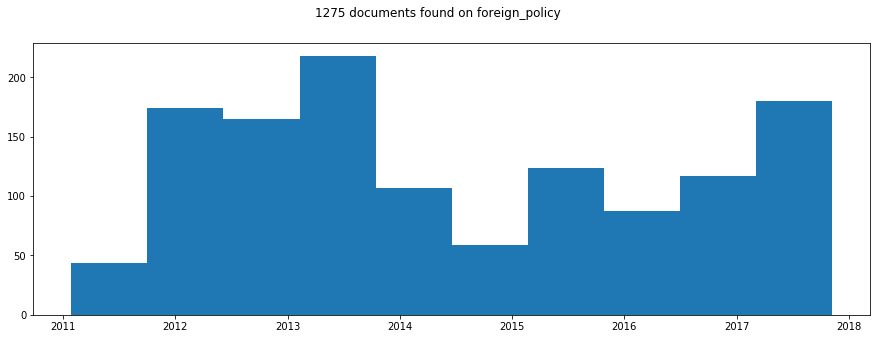

Tweets on trade :  

hillaryclinton channel john kerry trade bad trade deal tpp debate 

ohio gov kasich voted nafta ohio recovered want tpp worse ohio steel coal dying 

vote clinton kaine vote tpp nafta high tax radical regulation massive influx refugee 



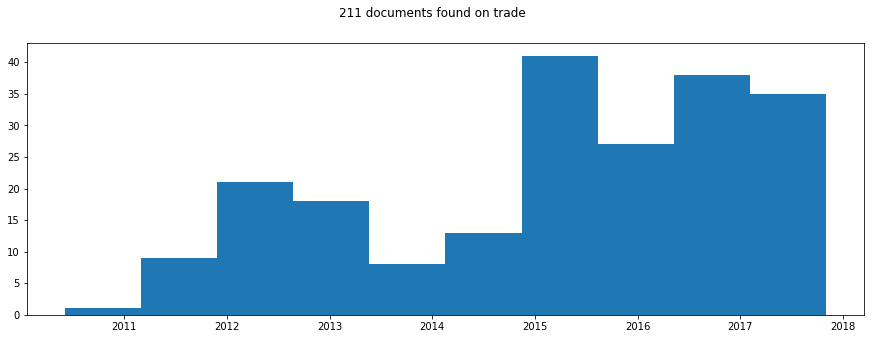

Tweets on gun :  

ammoland fredy riehl talk gun control assault weapon gun free zone self defense 

fact tighter gun law violence criminal gun 

gun trying kill reasonable shoot gun dalailama 



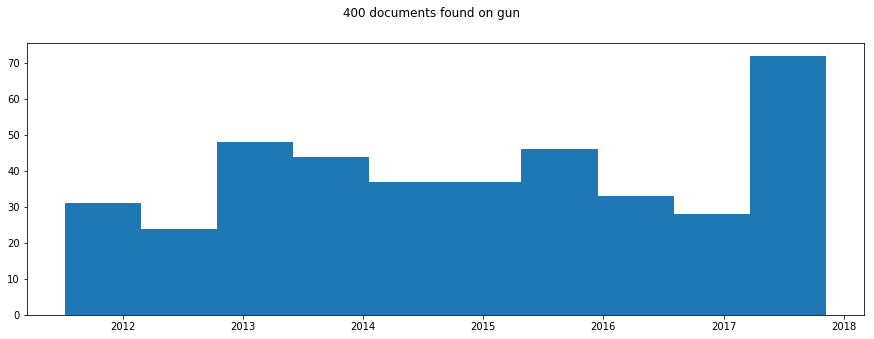

Tweets on healthcare :  

obamacare put poor people form government run single payer health insurance doctor avik 

great meeting ceo leading usa health insurance company provide great healthcare american peo 

insurance company fleeing obamacare dead healthcare plan lower premium deductible great healthcare 



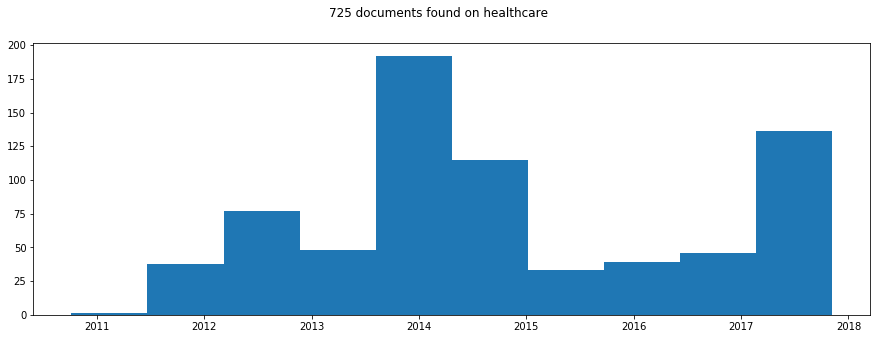

Tweets on immigration :  

wow pres candidate ben carson weak illegal immigration said like amnesty pathway citizenship 

congress protect border amnesty border secure illegal immigration stopped 

day said going build great wall southern border stop illegal immigration watch wednesday 



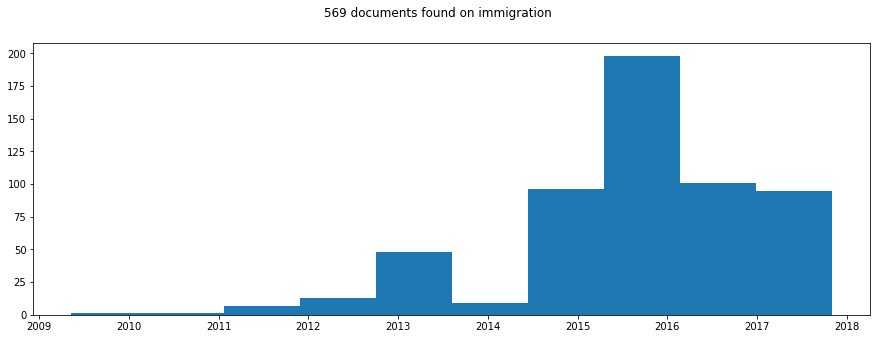

Tweets on jobs :  

bring job wage people wage increase year clinton killed job 

barackobama recovery unemployment underemployment business wo hire obama 

tragedy unemployment rate million unemployed american better 



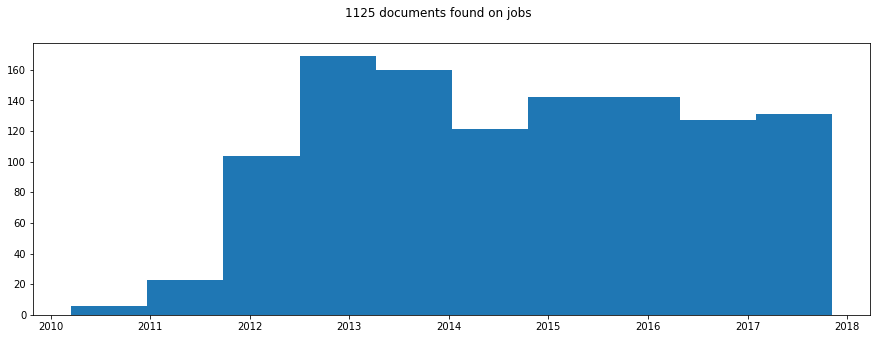

Tweets on tax :  

tax good thing dc debt deal 

democrat solution solution tax tax tax problem work timetogettough 

republican agreed past summer debt deal military cut come tax increase 



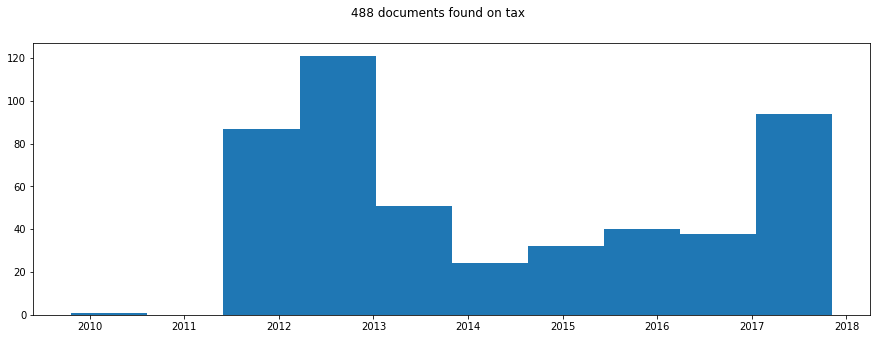

Tweets on technology :  

fix infrastructure country road airport bridge know build pol know talk 

america need rebuild infrastructure sending trillion overseas road bridge cont 

obama attack internet power grab net neutrality fairness doctrine target conservative medium 



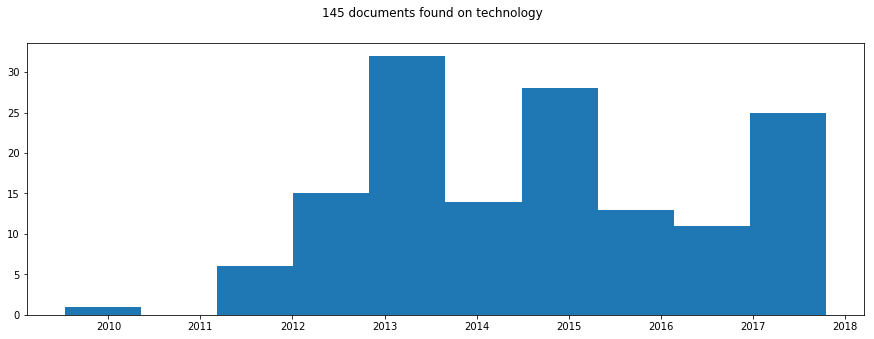

In [17]:
#elastic search on the tweet with words relevant to the topics as query
for topic in topics_dict.keys():
    res = es.search(index="tweets",query=topics_dict[topic],size="3000")
    topic_data = []
    count = 0
    tweets_to_display = []
    for doc in res['hits']['hits']:
        if(count < 3):
            tweets_to_display.append(doc['_source']['text'])
            count += 1
        topic_data.append(parser.parse(doc['_source']['created_at'].split()[0]))
    #plot top 3 tweets
    print ("Tweets on {} : ".format(topic),"\n")
    for tweet in tweets_to_display:
        print (tweet, "\n")
    #plot histogram
    if (res['hits']['total'] > 0):
        plt.figure(figsize=(15,5))
        plt.hist(topic_data)
        plt.suptitle(("{} documents found on {}".format(res['hits']['total'],topic)))
        plt.show()

# Discussion

In the first two models, we tried to group topics of Trump's tweets, we found them to be misleading based on the words that were used to identify a topic. We later built an initial dictionary to test whether elastic search would be a better approach to label trump's tweets. In fact, from this early stage approach to the project we found elastic search to be a better suit, but we will continue exploring the three different models and try to improve each of them to pick the best.<br/>Note here that the number of tweets that were obtained using elastic search were not satisfying as we should expect a larger number of tweets. We will also try to improve these results by improving our pre-processing as we may be turning the data into different words (i.e. after lemmatization)

# Twitter dump data preprocessing

# Sentiment analysis of replies to Trump

# Timeline of sentiment analysis

# Comparison of topic timeline to sentiment analysis timeline